## Classification using Ridge Classifier
This is an example showing how scikit-learn `RidgeClassifier` can be used to classify documents by topics using a Bag of Words approach.

### Load and vectorize text dataset
We define a function to load data form the 20 newsgroups text dataset, which comprises around 18,000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing.

1. Load dataset

In [6]:
# Import libraries
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# Define text categories
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

# Function to get the document size
def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6

# Load and vectorize the 20 newsgroups dataset
def load_dataset(verbose=False, remove=()):
    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )
    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # Order of labels in 'target_names' can be different from 'categories'
    target_names = data_train["target_names"]

    # Split target to training and testing sets
    y_train, y_test = data_train["target"], data_test["target"]

    # Extract features from training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train["data"])
    duration_train = time() - t0

    # Extract features from testing data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test["data"])
    duration_test = time() - t0
    feature_names = vectorizer.get_feature_names_out()

    return X_train, X_test, y_train, y_test, feature_names, target_names



### Train the classifier using the dataset
`RidgeClassifier` is a linear classification model that uses the mean squared error on {-1, 1} encoded targets, one for each possible class. 

2. Train the ridge classifier

In [7]:
# Import library
from sklearn.linear_model import RidgeClassifier

X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=False)

# Train the ridge classifier
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

3. Plot the confusion matrix

Find if there is a pattern in the classification errors.

Text(0.5, 1.0, 'Confusion Matrix for RidgeClassifier\non the original documents')

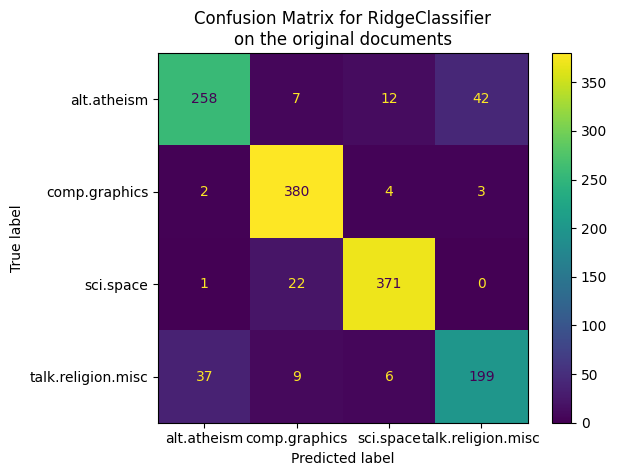

In [8]:
# Import libraries
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Create a plot
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

4. Analyze based on words with highest average feature effects

Top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


<Axes: title={'center': 'Average feature effect on original data'}>

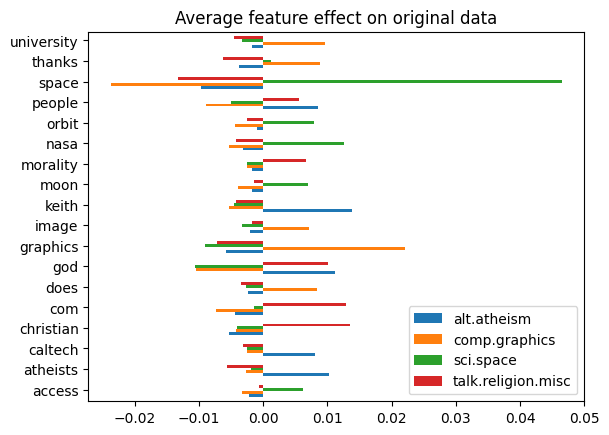

In [9]:
# Import libraries
import numpy as np
import pandas as pd 

# Define function to plot the feature effects
def plot_feature_effects():
    # Learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]

        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)

    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # Plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots()
    for i, label in enumerate(target_names):
        ax.barh(
            y=y_locs + (i - 2) * bar_size,
            width=average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4*bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")
    ax.set_title("Average feature effect on original data")
    print("Top 5 keywords per class:")
    print(top)

    return ax

plot_feature_effects()